# 演示skimage库中ssim函数的使用

官方源码如下：
源码来源：
https://github.com/scikit-image/scikit-image/blob/v0.18.0/skimage/metrics/_structural_similarity.py#L12-L232
说明文档：
https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity

功能：
计算两张图片的结构相似度
两张图片可以是任意的维度，也就是说对于高光谱图像也是适用的。

输入参数：
im1, im2 : ndarray
        Images. Any dimensionality with same shape.

输入的图片存储格式必须是ndarray格式

In [2]:
def structural_similarity(im1, im2,
                          *,
                          win_size=None, gradient=False, data_range=None,
                          multichannel=False, gaussian_weights=False,
                          full=False, **kwargs):
    """
    Compute the mean structural similarity index between two images.

    Parameters
    ----------
    im1, im2 : ndarray
        Images. Any dimensionality with same shape.
    win_size : int or None, optional
        The side-length of the sliding window used in comparison. Must be an
        odd value. If `gaussian_weights` is True, this is ignored and the
        window size will depend on `sigma`.
    gradient : bool, optional
        If True, also return the gradient with respect to im2.
    data_range : float, optional
        The data range of the input image (distance between minimum and
        maximum possible values). By default, this is estimated from the image
        data-type.
    multichannel : bool, optional
        If True, treat the last dimension of the array as channels. Similarity
        calculations are done independently for each channel then averaged.
    gaussian_weights : bool, optional
        If True, each patch has its mean and variance spatially weighted by a
        normalized Gaussian kernel of width sigma=1.5.
    full : bool, optional
        If True, also return the full structural similarity image.

    Other Parameters
    ----------------
    use_sample_covariance : bool
        If True, normalize covariances by N-1 rather than, N where N is the
        number of pixels within the sliding window.
    K1 : float
        Algorithm parameter, K1 (small constant, see [1]_).
    K2 : float
        Algorithm parameter, K2 (small constant, see [1]_).
    sigma : float
        Standard deviation for the Gaussian when `gaussian_weights` is True.

    Returns
    -------
    mssim : float
        The mean structural similarity index over the image.
    grad : ndarray
        The gradient of the structural similarity between im1 and im2 [2]_.
        This is only returned if `gradient` is set to True.
    S : ndarray
        The full SSIM image.  This is only returned if `full` is set to True.

    Notes
    -----
    To match the implementation of Wang et. al. [1]_, set `gaussian_weights`
    to True, `sigma` to 1.5, and `use_sample_covariance` to False.

    .. versionchanged:: 0.16
        This function was renamed from ``skimage.measure.compare_ssim`` to
        ``skimage.metrics.structural_similarity``.

    References
    ----------
    .. [1] Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P.
       (2004). Image quality assessment: From error visibility to
       structural similarity. IEEE Transactions on Image Processing,
       13, 600-612.
       https://ece.uwaterloo.ca/~z70wang/publications/ssim.pdf,
       :DOI:`10.1109/TIP.2003.819861`

    .. [2] Avanaki, A. N. (2009). Exact global histogram specification
       optimized for structural similarity. Optical Review, 16, 613-621.
       :arxiv:`0901.0065`
       :DOI:`10.1007/s10043-009-0119-z`

    """
    check_shape_equality(im1, im2)


    if multichannel:
        # loop over channels
        args = dict(win_size=win_size,
                    gradient=gradient,
                    data_range=data_range,
                    multichannel=False,
                    gaussian_weights=gaussian_weights,
                    full=full)
        args.update(kwargs)
        nch = im1.shape[-1]
        mssim = np.empty(nch)
        if gradient:
            G = np.empty(im1.shape)
        if full:
            S = np.empty(im1.shape)
        for ch in range(nch):
            ch_result = structural_similarity(im1[..., ch],
                                              im2[..., ch], **args)
            if gradient and full:
                mssim[..., ch], G[..., ch], S[..., ch] = ch_result
            elif gradient:
                mssim[..., ch], G[..., ch] = ch_result
            elif full:
                mssim[..., ch], S[..., ch] = ch_result
            else:
                mssim[..., ch] = ch_result
        mssim = mssim.mean()
        if gradient and full:
            return mssim, G, S
        elif gradient:
            return mssim, G
        elif full:
            return mssim, S
        else:
            return mssim


    K1 = kwargs.pop('K1', 0.01)
    K2 = kwargs.pop('K2', 0.03)
    sigma = kwargs.pop('sigma', 1.5)
    if K1 < 0:
        raise ValueError("K1 must be positive")
    if K2 < 0:
        raise ValueError("K2 must be positive")
    if sigma < 0:
        raise ValueError("sigma must be positive")
    use_sample_covariance = kwargs.pop('use_sample_covariance', True)


    if gaussian_weights:
        # Set to give an 11-tap filter with the default sigma of 1.5 to match
        # Wang et. al. 2004.
        truncate = 3.5


    if win_size is None:
        if gaussian_weights:
            # set win_size used by crop to match the filter size
            r = int(truncate * sigma + 0.5)  # radius as in ndimage
            win_size = 2 * r + 1
        else:
            win_size = 7   # backwards compatibility


    if np.any((np.asarray(im1.shape) - win_size) < 0):
        raise ValueError(
            "win_size exceeds image extent.  If the input is a multichannel "
            "(color) image, set multichannel=True.")


    if not (win_size % 2 == 1):
        raise ValueError('Window size must be odd.')


    if data_range is None:
        if im1.dtype != im2.dtype:
            warn("Inputs have mismatched dtype.  Setting data_range based on "
                 "im1.dtype.", stacklevel=2)
        dmin, dmax = dtype_range[im1.dtype.type]
        data_range = dmax - dmin


    ndim = im1.ndim


    if gaussian_weights:
        filter_func = gaussian_filter
        filter_args = {'sigma': sigma, 'truncate': truncate}
    else:
        filter_func = uniform_filter
        filter_args = {'size': win_size}


    # ndimage filters need floating point data
    im1 = im1.astype(np.float64)
    im2 = im2.astype(np.float64)


    NP = win_size ** ndim


    # filter has already normalized by NP
    if use_sample_covariance:
        cov_norm = NP / (NP - 1)  # sample covariance
    else:
        cov_norm = 1.0  # population covariance to match Wang et. al. 2004


    # compute (weighted) means
    ux = filter_func(im1, **filter_args)
    uy = filter_func(im2, **filter_args)


    # compute (weighted) variances and covariances
    uxx = filter_func(im1 * im1, **filter_args)
    uyy = filter_func(im2 * im2, **filter_args)
    uxy = filter_func(im1 * im2, **filter_args)
    vx = cov_norm * (uxx - ux * ux)
    vy = cov_norm * (uyy - uy * uy)
    vxy = cov_norm * (uxy - ux * uy)


    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2


    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    D = B1 * B2
    S = (A1 * A2) / D


    # to avoid edge effects will ignore filter radius strip around edges
    pad = (win_size - 1) // 2


    # compute (weighted) mean of ssim
    mssim = crop(S, pad).mean()


    if gradient:
        # The following is Eqs. 7-8 of Avanaki 2009.
        grad = filter_func(A1 / D, **filter_args) * im1
        grad += filter_func(-S / B2, **filter_args) * im2
        grad += filter_func((ux * (A2 - A1) - uy * (B2 - B1) * S) / D,
                            **filter_args)
        grad *= (2 / im1.size)


        if full:
            return mssim, grad, S
        else:
            return mssim, grad
    else:
        if full:
            return mssim, S
        else:
            return mssim

使用方法

(218, 178, 3)
0.6661528811318764


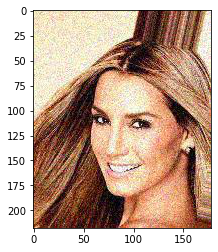

In [3]:
from skimage.metrics import structural_similarity as ssim
from skimage import io
import matplotlib.pyplot as plt

clean_img = io.imread('../000001.jpg')
plt.imshow(clean_img)

noise_img = io.imread('../noise_000001.jpg')
plt.imshow(noise_img)

print(noise_img.shape) #(218, 178, 3)
ssim_value = ssim(clean_img, noise_img, multichannel=True) #由于是3通道的数据，所以这里需要将multichannel设置为True
print(ssim_value)

## 处理高光谱图像

- 这个函数本身是支持多通道图像的处理的。最后的值为所有通道的平均值。
-     multichannel : bool, optional
        If True, treat the last dimension of the array as channels. Similarity
        calculations are done independently for each channel then averaged.
- 其返回值就是MSSIM

In [10]:
#三维立体数据，计算ssim

import numpy as np
hpy_image1 = np.ones((160,160, 16))
print(hpy_image1.shape)

hpy_image2 = np.ones((160,160,16))
print(hpy_image2.shape)

ssim_value = ssim(hpy_image1, hpy_image2, multichannel=True) 
print(ssim_value)

(160, 160, 16)
(160, 160, 16)
1.0


In [11]:
#4维数据，计算ssim
import numpy as np
hpy_image1 = np.ones((160,160, 16, 3))
print(hpy_image1.shape)

hpy_image2 = np.ones((160,160,16, 3))
print(hpy_image2.shape)

ssim_value = ssim(hpy_image1, hpy_image2, multichannel=True) 
print(ssim_value)

(160, 160, 16, 3)
(160, 160, 16, 3)
1.0


In [12]:
#4维数据，计算ssim
hpy_image1 = np.ones((3,160,160, 16))
print(hpy_image1.shape)

hpy_image2 = np.ones((3,160,160,16))
print(hpy_image2.shape)

ssim_value = ssim(hpy_image1, hpy_image2, multichannel=True) 
print(ssim_value)

(3, 160, 160, 16)
(3, 160, 160, 16)


ValueError: win_size exceeds image extent.  If the input is a multichannel (color) image, set multichannel=True.

## 错误分析
### ValueError: win_size exceeds image extent.  If the input is a multichannel (color) image, set multichannel=True.

I see. Please, double check https://scikit-image.org/docs/dev/api/skimage.metrics.html#skimage.metrics.structural_similarity . Particularly, it says that "multichannel: If True, treat the last dimension of the array as channels.". In your arrays of (16, 3, 128, 128), the first three dimensions are considered as spatial and the last one (128,) - as channels (since you set multichannel to True). Since the second dimension has lenght of 3, it is, most likely, smaller than the default win_size.

So, to run structural_similarity on your data, you will need to:

- Convert the inputs to numpy ndarrays, since scikit-image does not support pytorch tensors by design
- Move the axis (3, ) to the end, e.g. np.moveaxis(arr, 1, -3)
- Process each sample from the batch independently, since, I assume, you do not want to thread that dimension as spatial either.
On a side note, structural_similarity is implemented for numpy arrays only and it probably should not be used in pytorch pipeline, where one needs to have a pytorch-based differentiable function. Probably, what you are looking for is pytorch/pytorch#6934 .

I am going to close this tickets as I see no issue here on scikit-image side.

### 关于default win_size，根据如下源代码：默认情况下应该是7

if win_size is None:
        if gaussian_weights:
            # set win_size used by crop to match the filter size
            r = int(truncate * sigma + 0.5)  # radius as in ndimage
            win_size = 2 * r + 1
        else:
            win_size = 7   # backwards compatibility

In [13]:
#做测试，将第一维修改为7试一下，果然是ok的。
#4维数据，计算ssim
hpy_image1 = np.ones((7,160,160, 16))
print(hpy_image1.shape)

hpy_image2 = np.ones((7,160,160,16))
print(hpy_image2.shape)

ssim_value = ssim(hpy_image1, hpy_image2, multichannel=True) 
print(ssim_value)

(7, 160, 160, 16)
(7, 160, 160, 16)
1.0


- 根据错误分析，通过将第一维3，移动到最后一维试一下
- 通过实验发现，结果是ok的

In [16]:
#4维数据，计算ssim
hpy_image1 = np.ones((3,160,160, 16))
print(hpy_image1.shape)

hpy_image1 = np.moveaxis(hpy_image1, 0, -1) #把第0维移动到最后1维
print(hpy_image1.shape)

hpy_image2 = np.ones((3,160,160,16))
print(hpy_image2.shape)
hpy_image2 = np.moveaxis(hpy_image2, 0, -1) ##把第0维移动到最后1维
print(hpy_image2.shape)

ssim_value = ssim(hpy_image1, hpy_image2, multichannel=True) 
print(ssim_value)

(3, 160, 160, 16)
(160, 160, 16, 3)
(3, 160, 160, 16)
(160, 160, 16, 3)
1.0
